In [1]:
import nest
import numpy as np
import os
import matplotlib.pyplot as plt

nest.ResetKernel()


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: May 12 2025 17:47:05

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
nest.set(rng_type='Threefry_32', rng_seed=1234567)

In [3]:
n_groups = 8

exc_per_group = 100
inh_per_group = 25

# Time axis
T_ms = 2000.0
dt_ms = 1.0                  
times = np.arange(0.1, T_ms + dt_ms, dt_ms) 
n_steps = len(times)

# Rate modulation time constant
tau_ms = 50.0

# Rate statistics
mu_hz = 10.0                 # mean firing rate (Hz)
sigma_hz = 6.0               # variability (Hz)
min_rate_hz = 0.0
max_rate_hz = 60.0

# Connection weights (current-based neuron: negative weight = inhibitory)
w_e = 1.0     # pA (if iaf_psc_alpha)
w_i = -4.0    # pA
delay_ms = 1.5

Saved rate signals to cache: 


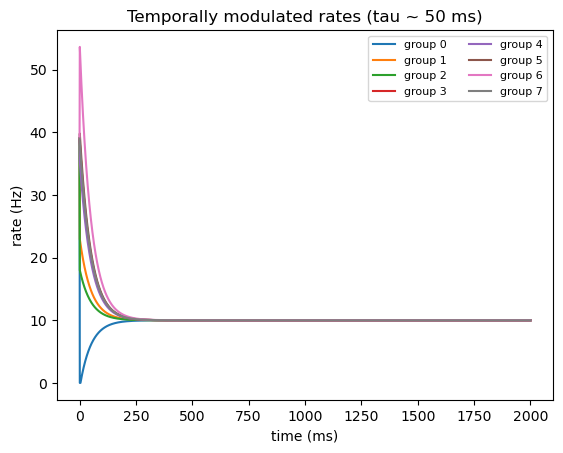

In [4]:

# ============================================================
# 3) Generate 8 independent temporally-smoothed rate signals (tau ~ 50 ms)
rates_hz = np.zeros((n_groups, n_steps), dtype=float)

alpha = dt_ms / tau_ms  # smoothing factor

for g in range(n_groups):
    rates_hz[:, 0] = mu_hz + sigma_hz * np.random.normal(g)
    for k in range(n_steps - 1):
        rates_hz[g, k + 1] = rates_hz[g, k] + alpha * (mu_hz - rates_hz[g, k])

    # clip to nonnegative and reasonable max
    rates_hz[g, :] = np.clip(rates_hz[g, :], min_rate_hz, max_rate_hz)

np.save('\content', rates_hz)
print(f"Saved rate signals to cache: ")

# Quick sanity plot of rate signals
plt.figure()
for g in range(n_groups):
    plt.plot(times, rates_hz[g], label=f"group {g}")
plt.xlabel("time (ms)")
plt.ylabel("rate (Hz)")
plt.title("Temporally modulated rates (tau ~ 50 ms)")
plt.legend(ncol=2, fontsize=8)
plt.show()


In [5]:
post = nest.Create("iaf_psc_alpha", 1)

# (Optional) Set some neuron parameters
nest.SetStatus(post, {
    "tau_m": 20.0,
    "E_L": -70.0,
    "V_th": -55.0,
    "V_reset": -70.0,
    "t_ref": 2.0,
    "I_e":500,
})


In [6]:
# In NEST, if you connect ONE generator to many targets, they share spikes.
# Here we want 125 distinct trains per group, so we need 125 generators per group.

total_syn = 1000
syn_per_group = 125

generators = nest.Create("inhomogeneous_poisson_generator", total_syn)
group_ids = np.repeat(np.arange(n_groups), syn_per_group)

# Assign rate profile per generator (group-specific)
# inhomogeneous_poisson_generator expects:
#   rate_times (ms) and rate_values (Hz)
status_list = []
for i in range(total_syn):
    g = group_ids[i]
    status_list.append({
        "rate_times": times,
        "rate_values": rates_hz[g],
    })
nest.SetStatus(generators, status_list)


In [7]:
# Build excit/inhib masks (within each group block of 125)
exc_gens = nest.NodeCollection()
inh_gens = nest.NodeCollection()

for g in range(n_groups):
    base = g * syn_per_group
    exc_gens += generators[base : base + exc_per_group]                 # 100
    inh_gens += generators[base + exc_per_group : base + syn_per_group] # 25

nest.Connect(exc_gens, post, syn_spec={"weight": w_e, "delay": delay_ms})
nest.Connect(inh_gens, post, syn_spec={"weight": w_i, "delay": delay_ms})

print(f"Connected {len(exc_gens)} excitatory and {len(inh_gens)} inhibitory synapses.")
print(f"Total synapses: {len(exc_gens) + len(inh_gens)}")



Connected 800 excitatory and 200 inhibitory synapses.
Total synapses: 1000


In [8]:

# 7) Record postsynaptic activity (spikes + Vm)
spk = nest.Create("spike_recorder")
mm = nest.Create("multimeter", params={"record_from": ["V_m"], "interval": 1.0})

nest.Connect(post, spk)
nest.Connect(mm, post)


In [9]:
# 8) the Run simulation
nest.Simulate(T_ms)


Jan 22 18:15:18 NodeManager::prepare_nodes [Info]: 
    Preparing 1003 nodes for simulation.

Jan 22 18:15:18 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1003
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Jan 22 18:15:21 SimulationManager::run [Info]: 
    Simulation finished.


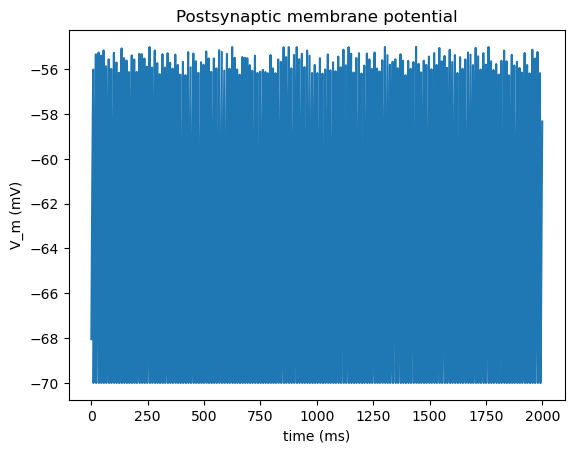

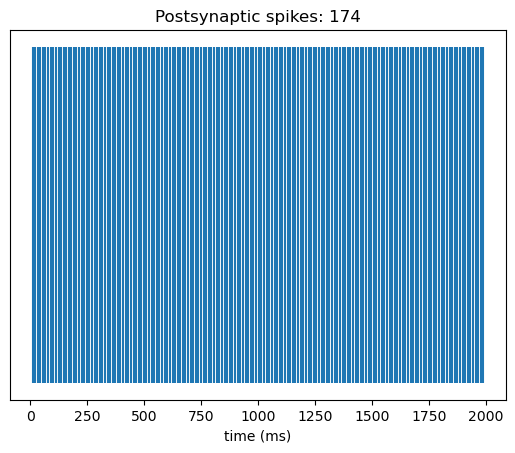

In [10]:
# 9) Plot results
events = nest.GetStatus(spk, "events")[0]
spike_times = events["times"]

vm_events = nest.GetStatus(mm, "events")[0]
t_vm = vm_events["times"]
V_m = vm_events["V_m"]

plt.figure()
plt.plot(t_vm, V_m)
plt.xlabel("time (ms)")
plt.ylabel("V_m (mV)")
plt.title("Postsynaptic membrane potential")
plt.show()

plt.figure()
plt.vlines(spike_times, 0, 1)
plt.xlabel("time (ms)")
plt.yticks([])
plt.title(f"Postsynaptic spikes: {len(spike_times)}")
plt.show()


In [11]:
exc_gens

NodeCollection(metadata=None,
               model=inhomogeneous_poisson_generator, size=100, first=2, last=101;
               model=inhomogeneous_poisson_generator, size=100, first=127, last=226;
               model=inhomogeneous_poisson_generator, size=100, first=252, last=351;
               model=inhomogeneous_poisson_generator, size=100, first=377, last=476;
               model=inhomogeneous_poisson_generator, size=100, first=502, last=601;
               model=inhomogeneous_poisson_generator, size=100, first=627, last=726;
               model=inhomogeneous_poisson_generator, size=100, first=752, last=851;
               model=inhomogeneous_poisson_generator, size=100, first=877, last=976)